In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mode
import seaborn as sns

In [2]:
df = pd.read_csv("igo_year_formatv3.csv", delimiter="	")

In [3]:
wanted_years = df.loc[df.year == 2012]

In [4]:
wanted_years.shape

(334, 235)

In [5]:
wanted_years.isnull().sum()

ioname               0
orgname              0
year                 0
afghanistan          0
albania              0
                  ... 
sourcesandnotes    334
imputed              0
political            0
social               0
economic             0
Length: 235, dtype: int64

In [6]:
country_columns = wanted_years.columns[3:220]
country_columns

Index(['afghanistan', 'albania', 'algeria', 'andorra', 'angola',
       'antiguabarbuda', 'argentina', 'armenia', 'australia', 'austria',
       ...
       'vietnam', 'wgermany', 'wsamoa', 'wurtenburg', 'yemen',
       'yugoslaviaserb', 'zaire', 'zambia', 'zanzibar', 'zimbabwe'],
      dtype='object', length=217)

In [7]:
for country in country_columns:
    n_nulls = wanted_years[country].isnull().sum()
    if n_nulls > 0:
        print(f"{country} has {n_nulls} nulls")

austriahungary has 315 nulls
baden has 315 nulls
bavariaelect has 315 nulls
czechoslovakia has 315 nulls
egermany has 315 nulls
hanover has 315 nulls
hesseelect has 315 nulls
hessegrand has 315 nulls
korea has 315 nulls
mecklenburg has 315 nulls
modena has 315 nulls
nyemen has 315 nulls
papalstates has 315 nulls
parma has 315 nulls
svietnam has 315 nulls
syemen has 315 nulls
saxony has 315 nulls
tuscany has 315 nulls
twosicilies has 315 nulls
wgermany has 315 nulls
wurtenburg has 315 nulls
zanzibar has 315 nulls


In [8]:
with open("country_columns.txt", 'w') as f:
    for country in country_columns:
        f.write(f"{country}\n")
    

In [10]:
# From happines report
with open("happiness_countries.txt", 'r') as f:
    countrys = f.readlines()

notacao_diff = {
    "unitedstates": "usa",
    "unitedkingdom": "uk",
    "centralafricanrepublic": "car",
    "southkorea": "sokorea",
    "czechrepublic": "czechrep",
    "southafrica": "soafrica",
    "dominicanrepublic": "domrepublic",
    "macedonia": "fyromacedonia",
    "unitedarabemirates": "uae",
}

countrys = set(map(lambda x: x.lower().replace("\n", "").replace(" ", ""), countrys))


set_not_in_hr = set()
for country in country_columns:
    country = country.lower().replace("\n", "").replace(" ", "")
    if not country in countrys and not country in notacao_diff.values():
        print(f"**{country}** nao esta no happiness")
        set_not_in_hr.add(country)
        
set_country_columns = set(country_columns)
set_country_columns = set_country_columns - set_not_in_hr

**andorra** nao esta no happiness
**antiguabarbuda** nao esta no happiness
**austriahungary** nao esta no happiness
**baden** nao esta no happiness
**bahamas** nao esta no happiness
**barbados** nao esta no happiness
**bavariaelect** nao esta no happiness
**belize** nao esta no happiness
**bhutan** nao esta no happiness
**bosnia** nao esta no happiness
**brunei** nao esta no happiness
**capeverde** nao esta no happiness
**congobrazz** nao esta no happiness
**cuba** nao esta no happiness
**czechoslovakia** nao esta no happiness
**dominica** nao esta no happiness
**egermany** nao esta no happiness
**etimor** nao esta no happiness
**eqguinea** nao esta no happiness
**eritrea** nao esta no happiness
**ethiopia** nao esta no happiness
**fiji** nao esta no happiness
**gabon** nao esta no happiness
**gambia** nao esta no happiness
**grenada** nao esta no happiness
**guineabissau** nao esta no happiness
**guyana** nao esta no happiness
**hanover** nao esta no happiness
**hesseelect** nao esta 

In [11]:
from tqdm import tqdm

In [12]:
intersecs = {}

for country_1 in tqdm(set_country_columns):
    for country_2 in set_country_columns:
        if country_1 != country_2:
            country_1_present = wanted_years[country_1]
            country_2_present = wanted_years[country_2]
            n_intersecs = len(wanted_years.loc[(country_1_present == 1.0) & (country_2_present == 1.0)])
            intersecs[(country_1, country_2)] = n_intersecs
                

100%|██████████| 140/140 [00:09<00:00, 14.69it/s]


In [ ]:
import pickle

with open("intersecs.pickle", 'wb') as f:
    pickle.dump(intersecs, f)
# with open("intersecs.pickle", 'rb') as f:
#     intersecs = pickle.load(f)

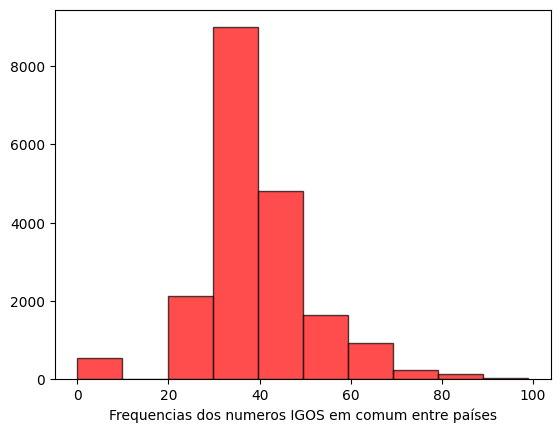

In [13]:
import matplotlib.pyplot as plt

intersecs_values = list(intersecs.values())
plt.hist(intersecs_values, color='red', alpha=0.7, edgecolor='black')
plt.xlabel('Frequencias dos numeros IGOS em comum entre países')
plt.show()

In [14]:
threshold = mode(intersecs_values)[0][0]
# threshold = sum(intersecs_values) / len(intersecs_values)
threshold

/tmp/ipykernel_174/109831930.py:1: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  threshold = mode(intersecs_values)[0][0]


35

In [15]:
import netpixi
from netpixi.integration.gt import *
from regression.integration.gt import *

<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()


In [16]:
g = Graph(directed=False)

for countrys, n_intersecs in intersecs.items():
    if n_intersecs > threshold:
        if not g.has_vertex(countrys[0]):
            v1 = g.add_vertex(countrys[0])
        if not g.has_vertex(countrys[1]):
            v2 = g.add_vertex(countrys[1])
            
        if not g.has_edge(countrys[0], countrys[1]):
            g.add_edge(countrys[0], countrys[1])

PATH_REDE = 'IGOS.net.gz'
gt_save(g, PATH_REDE)

In [17]:
n = g.num_vertices()
m = g.num_edges()

print(f"Número de arestas: {m}")
print(f"Número de vértices: {n}")

Número de arestas: 5591
Número de vértices: 138


In [18]:
max_edges = n * (n - 1) // 2
print(f"Número máximo de arestas: {max_edges}")
d = m / max_edges
print(f"Densidade: {d}")

Número máximo de arestas: 9453
Densidade: 0.5914524489580028


In [19]:
data = gt_data(g)

degrees = []
for v in g.all_vertices():
    degrees.append(v.total_degree())
    
data['degree'] = degrees

In [20]:
data['degree'].describe()

count    138.000000
mean      81.028986
std       32.060605
min        3.000000
25%       59.250000
50%       90.500000
75%      107.000000
max      125.000000
Name: degree, dtype: float64

<AxesSubplot: xlabel='degree', ylabel='Count'>

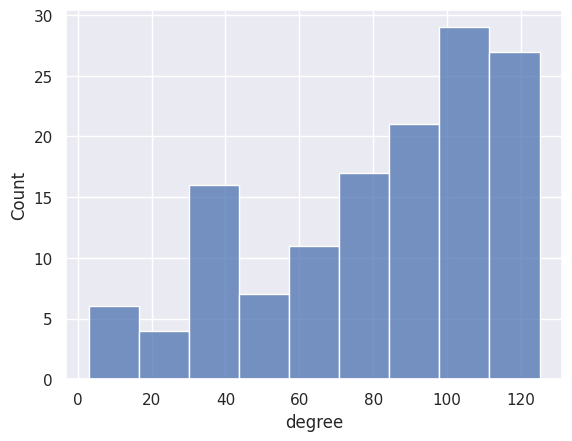

In [21]:
sns.histplot(data['degree'])

In [22]:
m = gt_draw.sfdp_layout(g)
gt_move(g, m)
gt_save(g, 'rede_sfdp.net.gz')
r = netpixi.render('rede_sfdp.net.gz', infinite=True);

In [23]:
r.vertex_set_key('id')

In [24]:
import cpnet

from graph_tool import spectral

<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()


In [25]:
matrix = spectral.adjacency(g)

# Além de cpnet.Rombach, há outras
# opções de algoritmos contínuos:
# cpnet.MINRES
# cpnet.Rossa

algorithm = cpnet.Rombach()
algorithm.detect(matrix)
c = algorithm.get_coreness()

# Depois do código acima, c é um dicionário
# em que as chaves são índices de vértices e
# valores são os atribuídos pelo algoritmo.

g.add_vp('coreness')
for i, coreness in c.items():
    v = g.get_vertex_by_index(i)
    v['coreness'] = float(coreness)

# Vamos usar coreness como referência para
# o tamanho dos vértices. Estabelecemos 10
# como o menor tamanho possível e 40 como
# o maior tamanho possível. Como o coreness
# está entre 0 e 1, a conta é bem simples.

for v in g.all_vertices():
    r.vertex(v['id'], size=(10 + 40 * v['coreness']))

# Quando a execução desta célula terminar,
# veja como ficou a visualização acima.

<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()


In [26]:
data = gt_data(g)

coreness = []
for v in g.all_vertices():
    coreness.append(v['coreness'])
    
data['coreness'] = coreness
data

,coreness
id,
netherlands,0.803571
czechrep,0.097727
nicaragua,0.154545
chile,0.222727
costarica,0.136364
...,...
afghanistan,0.025000
tajikistan,0.002273
uzbekistan,0.004545
